    В данном ноутбуке будут рассмотрены несколько нейросетей, каждая из которых будет классифицировать изображения рукописных цифр, рассмотрены различные методы построения сетей, сравниение нескольких различных функций активации, а также Functional API для построения сетей сложной структуры.
    
    Первый пример достаточно банален, это простая сеть с двумя скрытыми слоями, позволяется добиться точности на валидации порядка 0.96
    Второй пример уже немного интереснее, в нем испльзуется сверточная нейронная сеть с одним сверточным слоем. Такая модель уже дает качество порядка 0.98
    Третий использует три слоя, что позволяет извлечь больше фич. Это дает среди используемых, самую большую точность, 0.993.
    В четвертом показана попытка использовать увеличение stride вместо maxpoolling-а. В данной задаче, к сожалению, большого прироста в точности не дает.
    И, наконец, в пятом примере показан вариант построение нелинейной модели, использующий несколько схожих алгоритмов, но с разными функциями активации.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from keras.layers import Dense, Conv2D, Dropout, ReLU, Activation, Flatten, MaxPooling2D
from keras.models import Sequential

from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import keras

import albumentations


Using TensorFlow backend.


In [5]:

batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [8]:
def plot_education(model, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test, train_test_split = 0.25, epochs = 50, callbacks=None):
    history = model.fit(x_train, y_train, validation_split=0.25, epochs=epochs, batch_size=128, verbose=0, callbacks=callbacks)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    fig.suptitle('Metrics comparisson')
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.legend(['Train', 'Test'], loc='upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set(xlabel='Epochs', ylabel='Loss')

    ax2.legend(['Train', 'Test'], loc='upper left')
    
    plt.show()
    on_test = model.evaluate(x_test, y_test, verbose=0)
    print('loss     ---', on_test[0])
    print('accuracy ---', on_test[1])
    return model

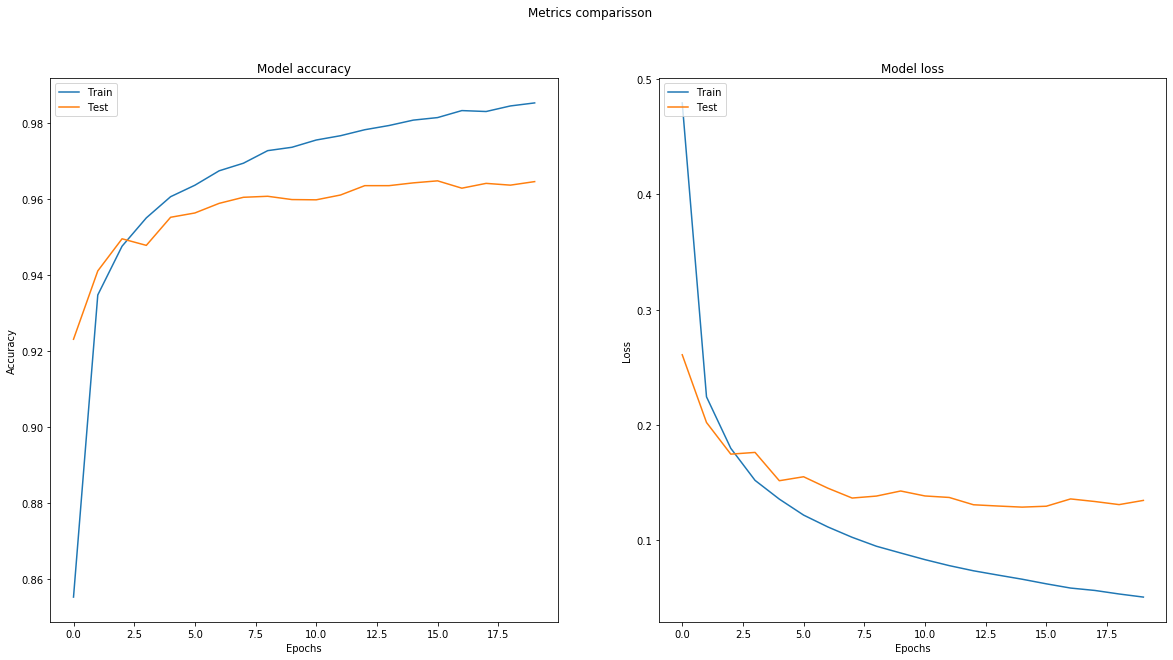

loss     --- 0.11441860508145764
accuracy --- 0.9684000015258789


In [13]:
callbacks = [ModelCheckpoint('Model_dense.h5', verbose=0, save_best_only=True, save_weights_only=False), EarlyStopping(monitor='val_loss', patience=5)]

model = Sequential()
model.add(Flatten())
model.add(Dense(32, activation='relu', input_shape=input_shape))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

plot_education(model, epochs=30, callbacks=callbacks)


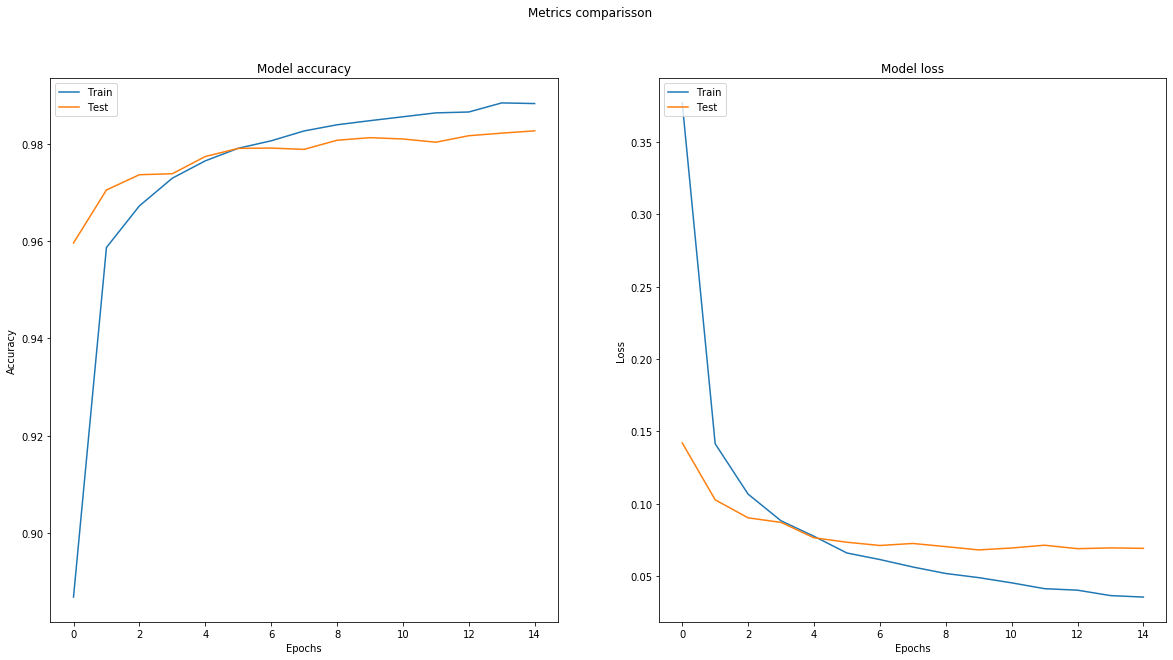

loss     --- 0.05489122534976923
accuracy --- 0.983299970626831


In [14]:
callbacks = [ModelCheckpoint('Model_colv_1_layer.h5', verbose=0, save_best_only=True, save_weights_only=False), EarlyStopping(monitor='val_loss', patience=5)]


model = Sequential()
model.add(Conv2D(filters = 10, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

plot_education(model, epochs=30, callbacks = callbacks)

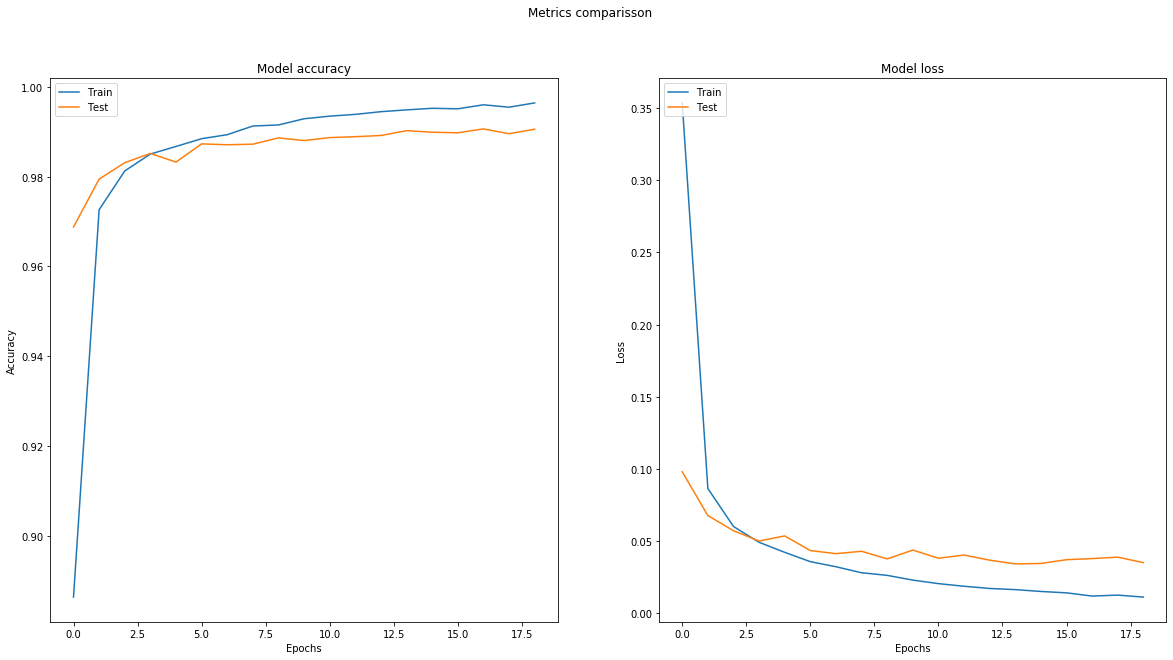

loss     --- 0.025802874730556234
accuracy --- 0.9930999875068665


In [28]:
from keras.layers import PReLU

callbacks = [ModelCheckpoint('Model_colv_3_layer.h5', verbose=0, save_best_only=True, save_weights_only=False), EarlyStopping(monitor='val_loss', patience=5)]


model = Sequential()
model.add(Conv2D(filters = 16, kernel_size=(3,3), input_shape=input_shape))
model.add(ReLU())
model.add(MaxPooling2D())
model.add(Conv2D(filters = 32, kernel_size=(3,3)))
model.add(ReLU())
model.add(MaxPooling2D())
model.add(Conv2D(filters = 64, kernel_size=(3,3)))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))



model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

best_model = plot_education(model, epochs=30, callbacks=callbacks)

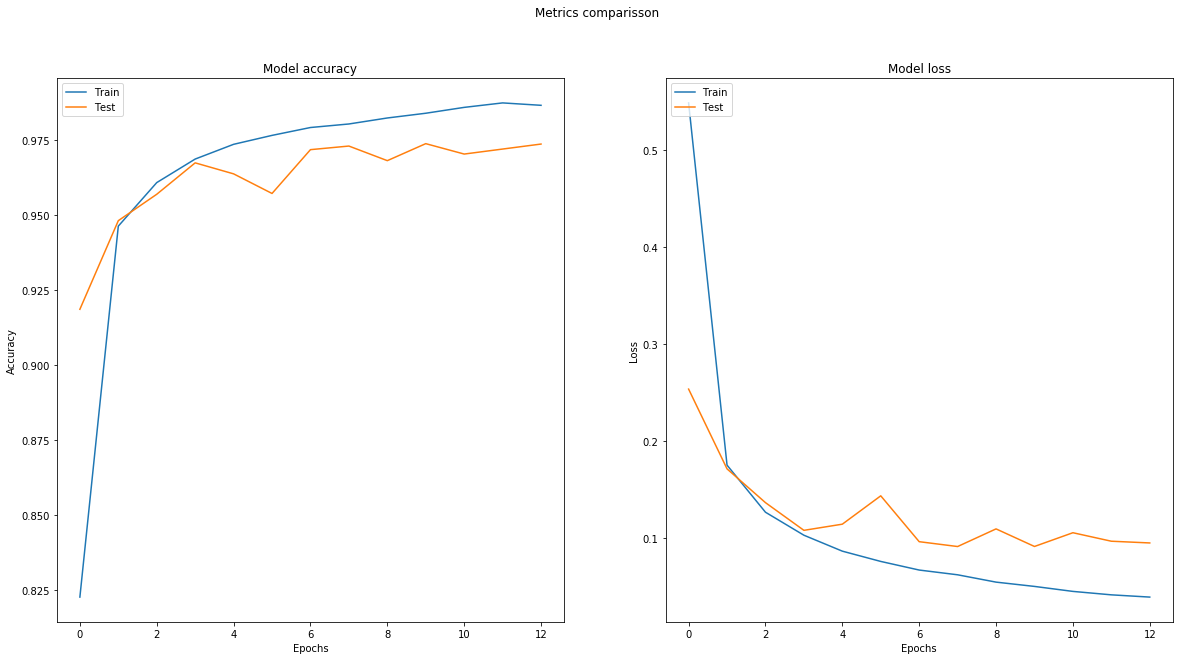

loss     --- 0.07727613445613533
accuracy --- 0.9761999845504761


In [27]:


callbacks = [ModelCheckpoint('Model_colv_3_layer_strides.h5', verbose=0, save_best_only=True, save_weights_only=False), EarlyStopping(monitor='val_loss', patience=5)]


model = Sequential()
model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', strides = [2,2], input_shape=input_shape))
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides = [4,4]))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu', strides = [8,8]))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))



model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

best_model = plot_education(model, epochs=30, callbacks=callbacks)

In [21]:
from keras.layers import ReLU, ELU, PReLU, concatenate
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

visible = Input(shape=(28,28,1))


conv1_1 = Conv2D(16, kernel_size=(3,3))(visible)
act1_1 = ReLU()(conv1_1)
pool1_1 = MaxPooling2D(pool_size=(2, 2))(act1_1)
conv1_2 = Conv2D(32, kernel_size=(3,3))(pool1_1)
act1_2 = ReLU()(conv1_2)
pool1_2 = MaxPooling2D(pool_size=(2, 2))(act1_2)
conv1_3 = Conv2D(64, kernel_size=(3,3))(pool1_2)
act1_3 = ReLU()(conv1_3)
pool1_3 = MaxPooling2D(pool_size=(2, 2))(act1_3)
dense1 = Dense(32)(Dropout(0.2)(Flatten()(pool1_1)))
flat1 = ReLU()(dense1)

conv2_1 = Conv2D(16, kernel_size=(3,3))(visible)
act2_1 = ELU()(conv2_1)
pool2_1 = MaxPooling2D(pool_size=(2, 2))(act2_1)
conv2_2 = Conv2D(32, kernel_size=(3,3))(pool2_1)
act2_2 = ELU()(conv2_2)
pool2_2 = MaxPooling2D(pool_size=(2, 2))(act2_2)
conv2_3 = Conv2D(64, kernel_size=(3,3))(pool2_2)
act2_3 = ELU()(conv2_3)
pool2_3 = MaxPooling2D(pool_size=(2, 2))(act2_3)
dense2 = Dense(32)(Dropout(0.2)(Flatten()(pool2_1)))
flat2 = ELU()(dense2)

merge = concatenate([flat1, flat2])

output = Dense(num_classes, activation='softmax')(merge)

# prediction output
model = Model(inputs=visible, outputs=output)


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])



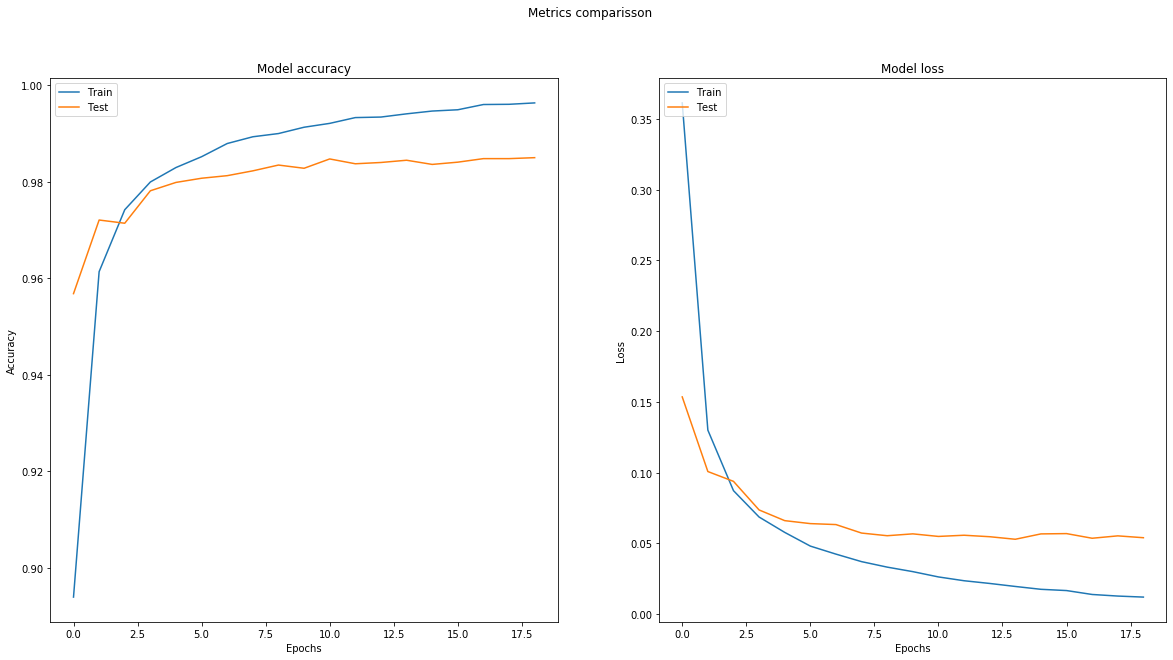

loss     --- 0.03893154888392164
accuracy --- 0.9883000254631042


In [22]:
callbacks = [ModelCheckpoint('Model_nonsequential.h5', verbose=0, save_best_only=True, save_weights_only=False), EarlyStopping(monitor='val_loss', patience=5)]


plot_education(model, epochs=30, callbacks=callbacks)